<a href="https://colab.research.google.com/github/PaulYYLin/CommonLit-KaggleComp/blob/main/CommonLit_Evaluate_Student_Summaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Connection

In [ ]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download "commonlit-evaluate-student-summaries"

In [ ]:
!unzip commonlit-evaluate-student-summaries.zip

# Main Execution

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import pandas as pd
import datetime
import os

## Data Preprocess

Remove stopwords --> Stem --> Tokenize --> padding --> Vectorized


In [ ]:
summ_t = pd.read_csv('summaries_train.csv')

In [ ]:
# Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocess Function
def wordProcess(content):
  tokens =[]
  token = content.split()
  for word in token:
    if word not in stop_words:
      tokens.append(ps.stem(word))

  return ' '.join(tokens)

#### summaries process

In [ ]:
# Left most freq words num
max_len_words = 100

# Volcabulary words num
top_words = 5000

summ_t_text = summ_t.text
print(f'Before: {summ_t_text[0]}')

# Remove Stopwords, Stemming
summ_t_text = summ_t_text.map(wordProcess)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words)

# Tokenize, Padding, Vectorize
tokenizer.fit_on_texts(summ_t_text)
summ_t_text = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(summ_t_text), maxlen=max_len_words)

print(f'After: {summ_t_text[0]}')

print(f'Shape of Data: {summ_t_text.shape}', f'Word token nums: {len(tokenizer.word_index)}', end ='\r')

Before: The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader
After: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    2   49   56  326   10 1850  272   20  379
  195   11  540 1174   10  132  284  272  266    2   19   86  186  214
  107  314 1448  540  245   73   13  548 1407   68   10  172 3776 1780
   86  379]


#### prompts process

In [ ]:
prompt_t = pd.read_csv('prompts_train.csv')

In [ ]:
prompt_t_q = prompt_t.prompt_question
prompt_t_q = prompt_t_q.map(process)
print(f'prompt_question: {prompt_t_q[0]}')

prompt_question: summar least 3 element ideal tragedy, describ aristotle.


In [ ]:
prompt_t_text = prompt_t.prompt_text
prompt_t_text = prompt_t_text.map(process)
print(f'prompt_text: {prompt_t_text[0]}')

prompt_text: chapter 13 as sequel alreadi said, must proceed consid poet aim at, avoid, construct plots; mean specif effect tragedi produced. a perfect tragedi should, seen, arrang simpl complex plan. it should, moreover, imit action excit piti fear, distinct mark tragic imitation. it follow plainly, first place, chang fortun present must spectacl virtuou man brought prosper adversity: move neither piti fear; mere shock us. nor, again, bad man pass advers prosperity: noth alien spirit tragedy; possess singl tragic quality; neither satisfi moral sens call forth piti fear. nor, again, downfal utter villain exhibited. a plot kind would, doubtless, satisfi moral sense, would inspir neither piti fear; piti arous unmerit misfortune, fear misfortun man like ourselves. such event, therefore, neither piti terrible. there remains, then, charact two extrem — man emin good just, yet whose misfortun brought vice depravity, error judgement frailty. he must one highli renown prosper — personag like o

In [ ]:
# padding
prompt_t_q = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(prompt_t_q), maxlen=380)
print(prompt_t_q.shape)

(4, 380)


In [ ]:
# padding
prompt_t_text = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(prompt_t_text), maxlen=380)
print(prompt_t_text.shape)

(4, 380)


#### summries & prompts

## Model

Model Build --> Hyperparameters Optimization --> Model Training --> Training Visualization

1. content >>> wording score

#### Content >>> Wording Score

In [ ]:
X = summ_t_text
y = summ_t.wording.values

In [ ]:
%pip install optuna

##### Hyper Parameters Optimization

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split


def objective(trial, X=X, y=y):
    """
    A function to train a model using different hyperparamerters combinations provided by Optuna.
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

    params = {
        'output_dim': trial.suggest_int('output_dim', 32, 64, 8),
        "LSTM_units": trial.suggest_int("LSTM_units", 8, 32, 8),
        'FC1_output': trial.suggest_int('FC_output', 8, 16, 4),
        'batch_size' : trial.suggest_int('batch_size', 32, 128, 32)
    }

    # Model build
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=top_words ,output_dim= params['output_dim'])) # Embedding from total top words dim >> output dim
    model.add(layers.LSTM(32))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

    model.fit(X_train,y_train,batch_size=params['batch_size'],epochs=10)
    mse = tf.keras.losses.MeanSquaredError()


    return mse(y_valid, model.predict(X_valid)).numpy()

%%time
# Creating Optuna object and defining its parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 10)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [ ]:
hp_dict = study.best_trial.params
print(hp_dict)

{'output_dim': 48,
 'LSTM_units': 8,
 'FC_output': 12,
 'FC1_activation': 'LeakyReLu',
 'batch_size': 32}

##### Model Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = keras.Sequential()
model.add(layers.Embedding(input_dim=top_words ,output_dim=hp_dict['output_dim'])) # Embedding from total top words dim >> output dim
model.add(layers.LSTM(hp_dict['LSTM_units']))
model.add(layers.Dense(hp_dict['FC_output'], activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())


(5015, 100) (5015,) (2150, 100) (2150,)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 48)          240000    
                                                                 
 lstm_28 (LSTM)              (None, 8)                 1824      
                                                                 
 dense_51 (Dense)            (None, 12)                108       
                                                                 
 dense_52 (Dense)            (None, 1)                 13        
                                                                 
Total params: 241945 (945.10 KB)
Trainable params: 241945 (945.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Call Back : https://ithelp.ithome.com.tw/articles/10234641

##### Training Visualization

In [ ]:
my_callbacks = [
    # Stop training when performance not improving
    tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_loss'),
    # Automatic adjust learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

history = model.fit(X_train,y_train, validation_data = (X_test, y_test),batch_size=study.best_trial.params['batch_size'],epochs=30 ,callbacks=my_callbacks)

Epoch 1/30
157/157 [==============================] - 10s 52ms/step - loss: 0.6901 - val_loss: 0.8077 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 7s 45ms/step - loss: 0.6900 - val_loss: 0.8037 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 7s 43ms/step - loss: 0.6874 - val_loss: 0.8066 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 8s 51ms/step - loss: 0.6853 - val_loss: 0.8074 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 7s 43ms/step - loss: 0.6866 - val_loss: 0.8061 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 8s 48ms/step - loss: 0.6817 - val_loss: 0.8063 - lr: 2.0000e-04
Epoch 7/30
157/157 [==============================] - 6s 40ms/step - loss: 0.6802 - val_loss: 0.8067 - lr: 2.0000e-04


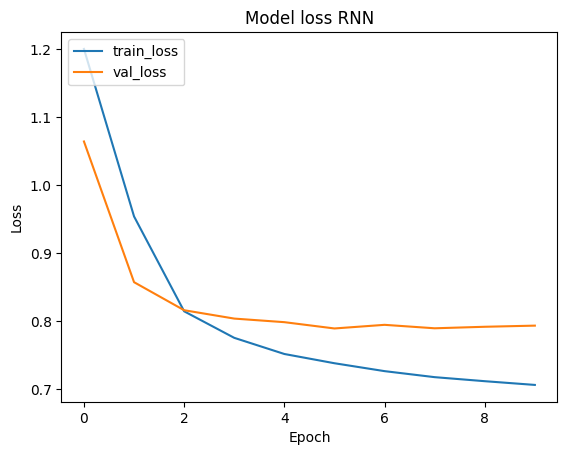

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()